# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [18]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [19]:
data = pd.read_csv("baseCVs.csv")
#Borramos el nombre de la CV ya que no lo usaremos para nuestro modelo
data = data.drop('CV_Name', axis=1)
data

,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Education_Exists,Education_Word_Count,Work_Experience_Exists,Work_Experience_Word_Count,Skills_Exists,...,Certifications_Word_Count,Achievements_Exists,Achievements_Word_Count,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed
0,378,0,1,1,9,1,19,1,239,1,...,0,0,0,1,26,1,50,0,0,1
1,695,1,1,4,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,656,1,1,3,13,1,1,1,24,1,...,0,0,0,1,28,0,0,0,0,1
3,2355,0,1,10,14,1,18,1,101,1,...,0,0,0,1,1,1,252,0,0,1
4,1129,0,1,4,11,1,13,0,0,1,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,524,0,1,1,5,1,43,0,0,1,...,0,0,0,1,3,1,142,1,29,0
302,1416,1,1,6,14,1,17,0,0,1,...,0,0,0,0,0,1,123,0,0,0
303,3729,1,1,10,14,1,3,0,0,1,...,0,0,0,1,18,1,425,0,0,0
304,899,0,1,3,8,1,28,1,26,1,...,0,0,0,1,47,1,11,0,0,0


### Descriptivo de la base

In [20]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Total_Word_Count                 306 non-null    int64
 1   Has_Photo                        306 non-null    int64
 2   Has_Colors                       306 non-null    int64
 3   Pages                            306 non-null    int64
 4   Keyword_Count                    306 non-null    int64
 5   Education_Exists                 306 non-null    int64
 6   Education_Word_Count             306 non-null    int64
 7   Work_Experience_Exists           306 non-null    int64
 8   Work_Experience_Word_Count       306 non-null    int64
 9   Skills_Exists                    306 non-null    int64
 10  Skills_Word_Count                306 non-null    int64
 11  Certifications_Exists            306 non-null    int64
 12  Certific

### División de la base en Train y Test

In [21]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (214, 22)
Forma de x_test: (92, 22)
Forma de y_train: (214,)
Forma de y: (92,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [23]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Precisión: 0.6195652173913043
Precisión: 0.3333333333333333
Recuperación: 0.029411764705882353
Puntuación F1: 0.05405405405405406
AUC ROC: 0.5147058823529411
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.63      0.97      0.76        58
           1       0.33      0.03      0.05        34

    accuracy                           0.62        92
   macro avg       0.48      0.50      0.41        92
weighted avg       0.52      0.62      0.50        92


Ranking de variables por importancia de Random Forest:
Education_Word_Count               0.132171
Total_Word_Count                   0.116950
Skills_Word_Count                  0.109361
projects_Word_Count                0.102049
Professional_Profile_Word_Count    0.088212
Pages                              0.083516
Keyword_Count                      0.075562
Work_Experien

In [24]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
volunteer_work_Exists              0.032310
Keyword_Count                      0.028252
Total_Word_Count                   0.021699
Work_Experience_Exists             0.014177
Education_Word_Count               0.012995
Professional_Profile_Exists        0.004965
Certifications_Word_Count          0.000000
projects_Word_Count                0.000000
Projects_Exists                    0.000000
Professional_Profile_Word_Count    0.000000
Achievements_Word_Count            0.000000
Achievements_Exists                0.000000
Skills_Word_Count                  0.000000
Certifications_Exists              0.000000
Has_Photo                          0.000000
Skills_Exists                      0.000000
Work_Experience_Word_Count         0.000000
Education_Exists                   0.000000
Pages                              0.000000
Has_Colors                         0.000000
volunteer_work_Word_Count          0.000000
dtype: float64


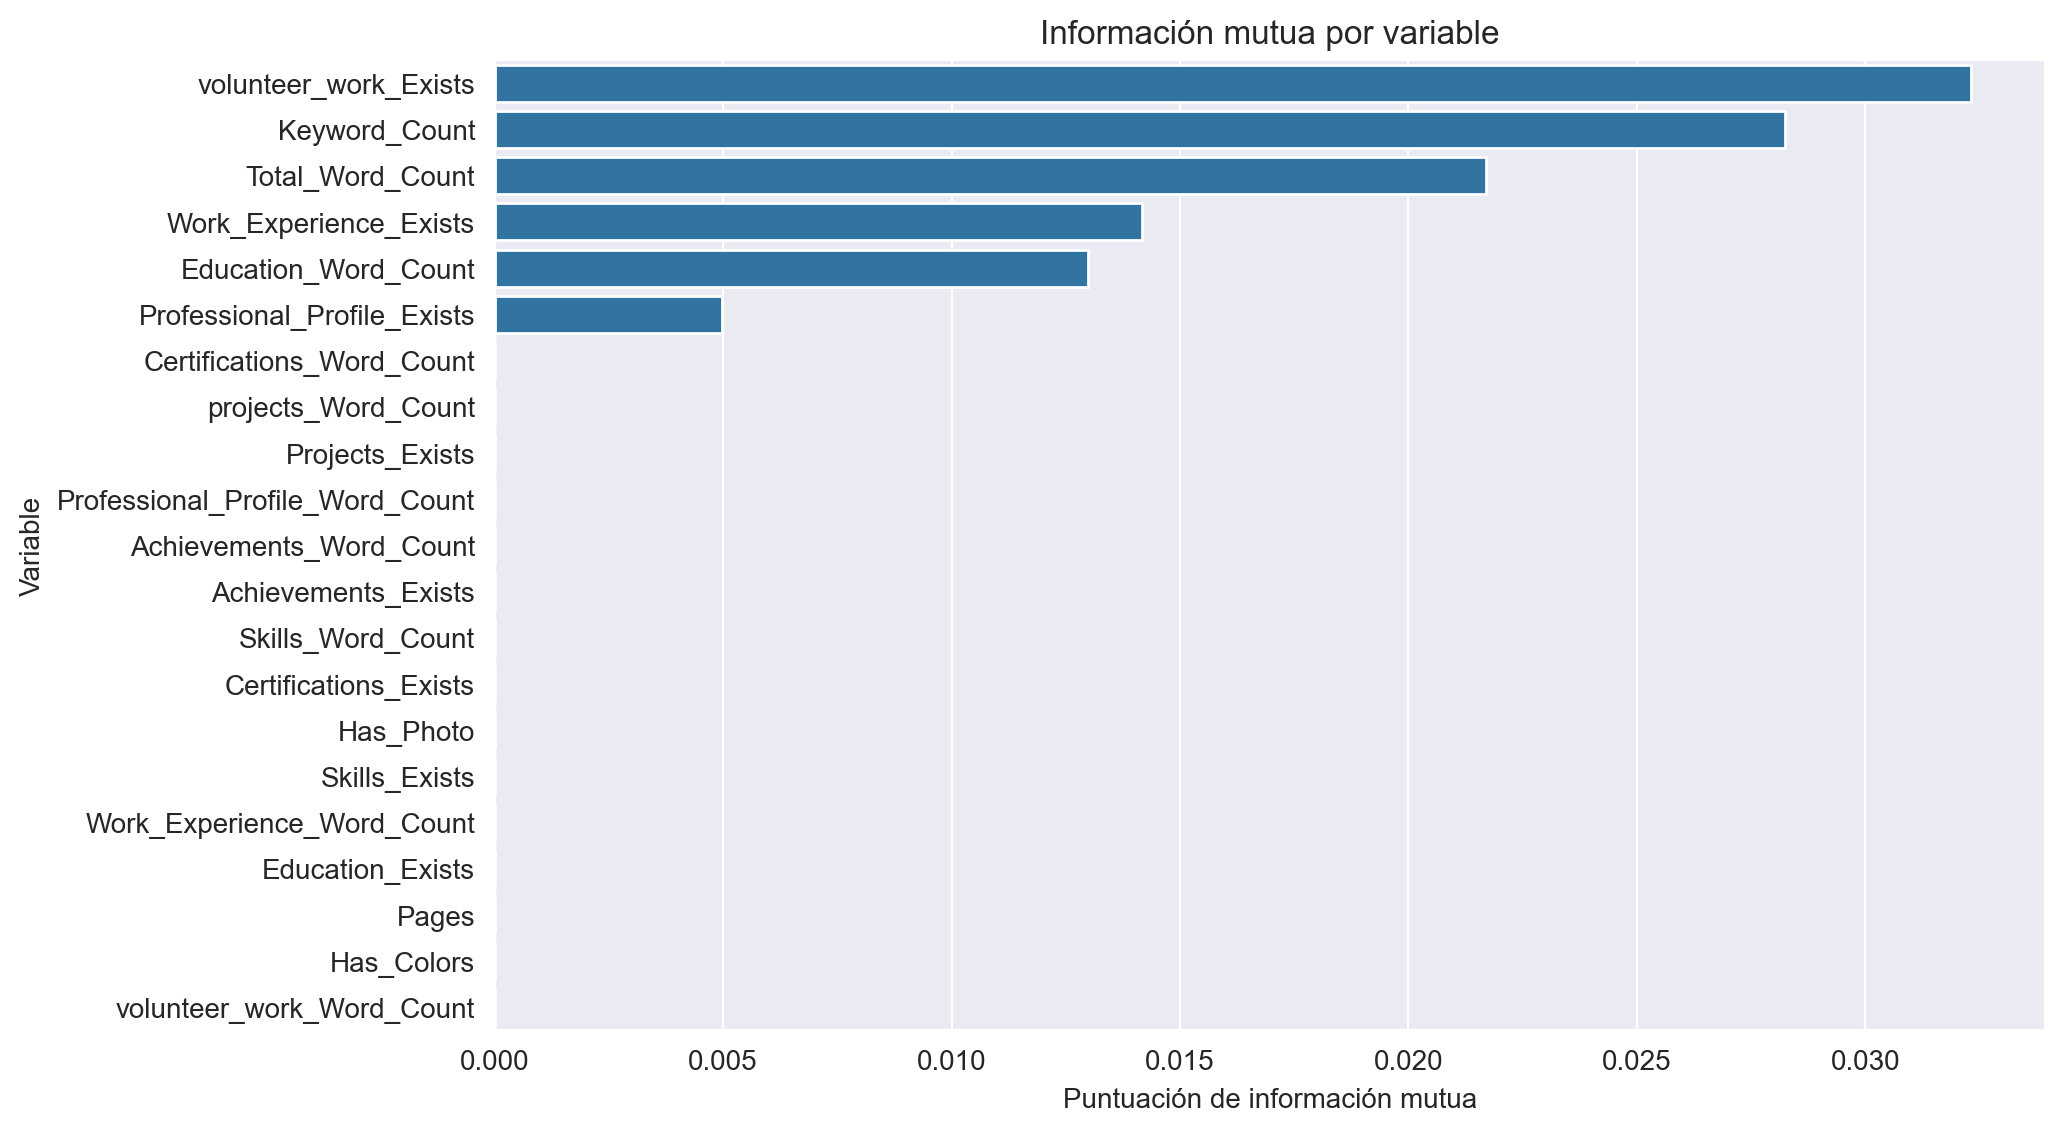

In [25]:
feature_scores = analizar_relevancia_informacion_mutua(data)